# Visualization notebook for GP experiments and learning

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern, WhiteKernel
from sklearn.model_selection import train_test_split

from plotters import plot_gp, plot_gp_example

# Short example visualization

In [2]:
def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y1 = f(X).ravel()
dy = 0.5 + 1.0 * np.random.random(y1.shape)
noise = np.random.normal(0, dy)
y1 += noise

# Instantiate a Gaussian Process model
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 10, 1000)).T
# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y1)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

In [3]:
np.diag(sigma).shape

(1000, 1000)

In [4]:
x.shape

(1000, 1)

(1000, 1000)


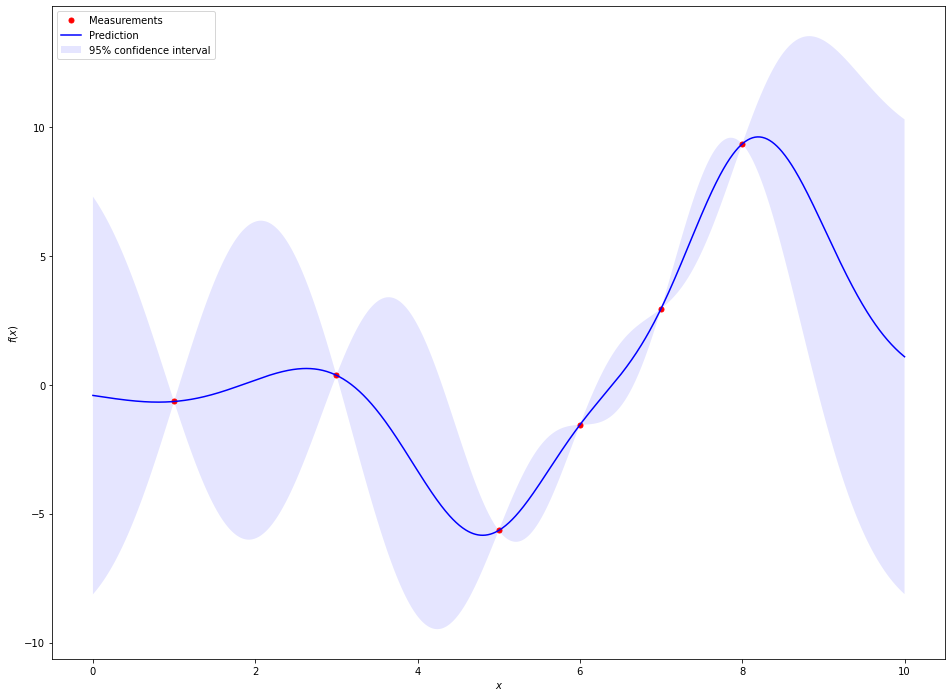

In [8]:
plot_gp_example(x, X, y1, y_pred, sigma)

# Simple time series

In [9]:
df = pd.read_csv('../data/mergedData.csv')
df.set_index('Timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

In [10]:
df = df.loc[:,'Pos1m3DO'].dropna()

In [11]:
train, test = train_test_split(df, test_size=0.2)

In [12]:
# List of dates for prediction, 1 minute interval
X = df.index.values
X_train = train.index.values
y = df.values
y_train = train.values
timeList = np.arange(
        '2019-07-02T12:00:00.0000000',
        '2019-07-06T00:00:00.0000000',
        np.timedelta64(1, 'm'),
        dtype='datetime64'
    )

# Format inputs
X = X.reshape(len(X), 1)
timeList = timeList.reshape(len(timeList), 1)
X = [pd.to_numeric(time, downcast='float') for time in X]
timeList = [pd.to_numeric(time, downcast='float') for time in timeList]

X_and_timeList = [*X, *timeList]

In [13]:
#kernel = Matern(length_scale=1.0, nu=1.0)
#kernel = ConstantKernel(1.0) * RBF(length_scale=1.0) + WhiteKernel(1.0)
length_scale_param=1.9
length_scale_bounds_param=(1e-05, 100000.0)
nu_param=2.5
matern=Matern(length_scale=length_scale_param, length_scale_bounds=length_scale_bounds_param, nu=nu_param)
kernel = matern + WhiteKernel()
gpr = GaussianProcessRegressor(
    kernel=kernel, 
    n_restarts_optimizer=9, 
    normalize_y=True,
)

In [14]:
#gp1_prior_samples = gp1.sample_y(X = X, n_samples=train.shape[0])
gpr.fit(X[:400:4], y[:400:4])
#gpr_prior_samples = gpr.sample_y(X= timeList[:600], n_samples = 1).T
#Posterior predictive mean and covariance
y_pred, y_cov = gpr.predict(timeList[200:700], return_cov=True)

In [15]:
timeList.shape

AttributeError: 'list' object has no attribute 'shape'

(500,)


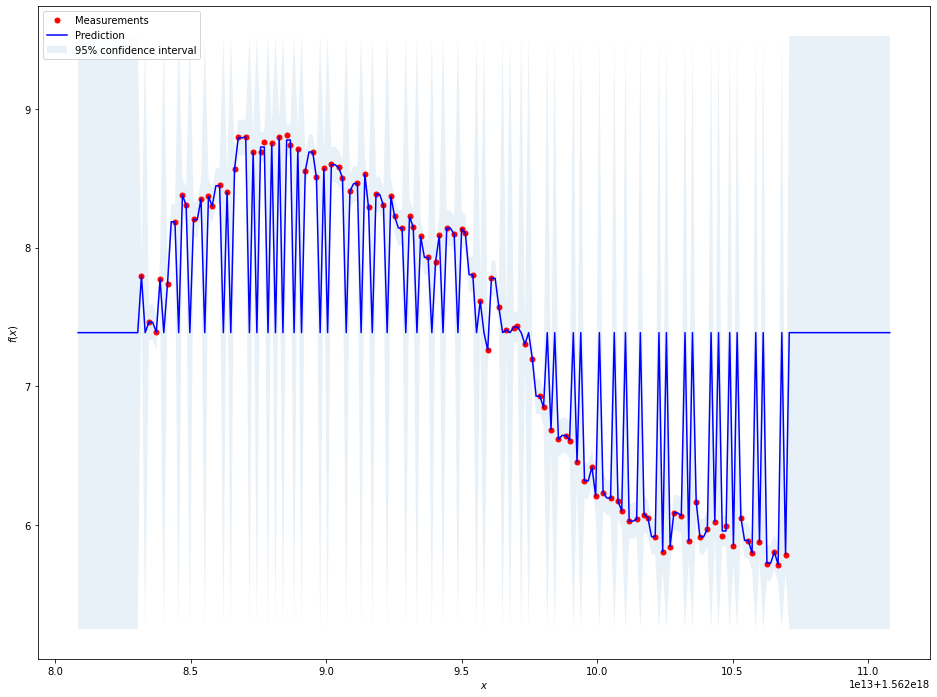

In [16]:
plot_gp(timeList[200:700], X[:400:4], y[:400:4], y_pred, y_cov)

In [ ]:
fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=X[...,0], y = gp1_prior_samples[:, i], alpha=0.2, ax=ax)
sns.lineplot(x=X[...,0], y=train.values[..., 0], label='y1', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP1 Prior Samples', xlabel='t');